# Demo No. 1 - Light curve fitting of spotty binaries.

This demo wil guide you trough basic principles of fitting spots to surfaces of eclipsing binaries which light curves shows variations due to spot activity.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import os

import astropy.units as u

from elisa.conf import config
from elisa.analytics import LCData
from elisa.analytics import BinarySystemAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging() 

This demo will demonstrate the spot fitting capability on example of RT LMi `cite source`. A usual, lets load the observations to our `DatraSet` structures:

In [3]:
lcBfile = 'demo_data/lc_data/RTLMi_B.dat'
lcVfile = 'demo_data/lc_data/RTLMi_V.dat'
lcRfile = 'demo_data/lc_data/RTLMi_R.dat'
lcIfile = 'demo_data/lc_data/RTLMi_I.dat'
zero_mag = 11.35
time_unit = u.d
flux_unit = u.mag

lcB = LCData.load_from_file(filename=lcBfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)
lcV = LCData.load_from_file(filename=lcVfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)
lcR = LCData.load_from_file(filename=lcRfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)
lcI = LCData.load_from_file(filename=lcIfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)

followed by defining of our `AnalyticsTask` instance. 

In [4]:
task = BinarySystemAnalyticsTask(light_curves={
    'Generic.Bessell.B': lcB,
    'Generic.Bessell.V': lcV,
    'Generic.Bessell.R': lcR,
    'Generic.Bessell.I': lcI
})

Make sure that `light_curve` argument keys - passband names are identical to passband names accesible for your Elisa install:

In [5]:
config.PASSBANDS

['bolometric',
 'Generic.Bessell.U',
 'Generic.Bessell.B',
 'Generic.Bessell.V',
 'Generic.Bessell.R',
 'Generic.Bessell.I',
 'SLOAN.SDSS.u',
 'SLOAN.SDSS.g',
 'SLOAN.SDSS.r',
 'SLOAN.SDSS.i',
 'SLOAN.SDSS.z',
 'Generic.Stromgren.u',
 'Generic.Stromgren.v',
 'Generic.Stromgren.b',
 'Generic.Stromgren.y',
 'Kepler',
 'GaiaDR2']

Suppose, that we already performed light curve fitting using binary model without spots. Lets load the fitted parameters:

In [6]:
task.lc_fit.load_parameters(filename='demo_data/aux/RT_LMi_lc_lstsqr.json')
task.lc_fit.fit_summary()

# BINARY SYSTEM
# Parameter                                        value            -1 sigma            +1 sigma                unit    status                                            
#-----------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            0.362                                                                Fixed                                             
Semi major axis (a):                               2.641                                                      solRad    2.6265959 / sin(radians({inclination}))           
Inclination (i):                                    84.0                                                      degree    Variable                                          
Eccentricity (e):                                    0.0                                                                Fixed                                             
Ar

and visualize the result (`data_frac_to_normalize` parameter describes how big portion of the observational data should be used for normalization to reduce the effect of the uotliers. Fitting procedure itself uses different normalization approach where the effects of uotliers are reduced by default.):

<IPython.core.display.Javascript object>


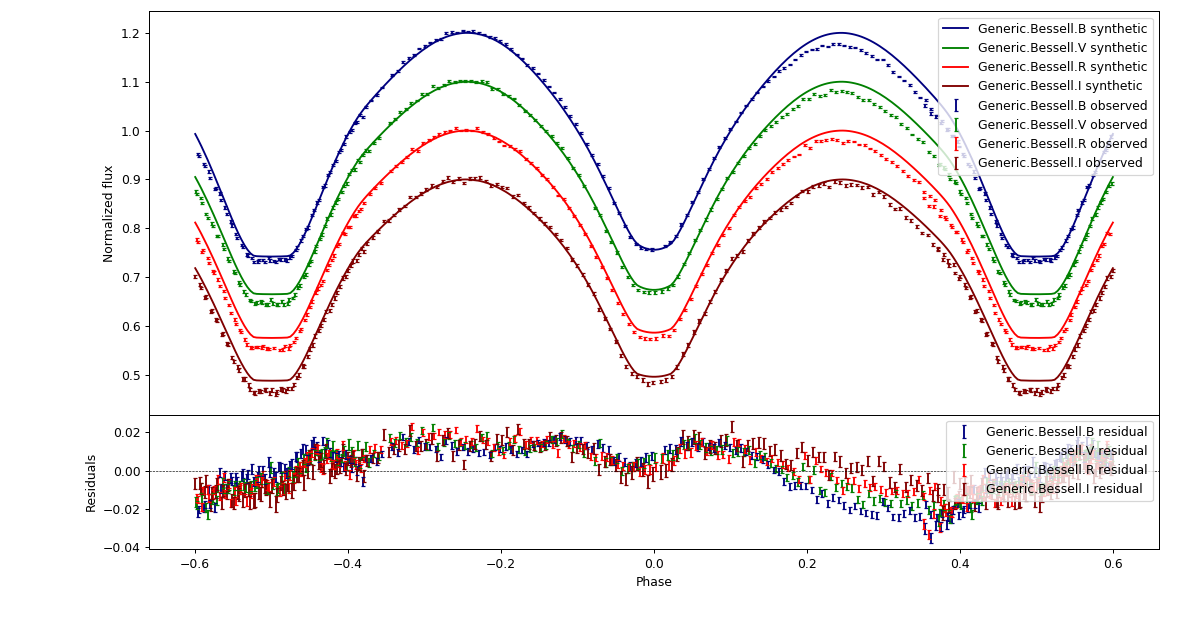

In [7]:
task.lc_fit.plot.model(data_frac_to_normalize=0.05)

As you can see, the ashape of the lightcurve is significantly infulenced by the presence of the surface inhomogeneities which we will try to model as stellar spots.

We will now investigate whether the light curve asymmetry can be explained by the presence of cold spot on the far side of primary component. We will now define initial parameter dictionary of spots for primary component where each spot should be named uniquely. Name of the spot should be unique globally (i.e. there cannot be a spot on the secondary component with the same name):

In [8]:
p_spots = {
    'spot1': {
        'longitude': {
            'value': 230,
            'fixed': False,
            'min': 180,
            'max': 270,
            'unit': u.degree
        },
        'latitude': {
            'value': 45,
            'fixed': False,
            'min': 0,
            'max': 90,
            'unit': u.degree
        },
        'angular_radius': {
            'value': 50,
            'fixed': False,
            'min': 45,
            'max': 80,
            'unit': u.degree
        },
        'temperature_factor': {
            'value': 0.98,
            'fixed': False,
            'min': 0.93,
            'max': 1.00,
        }
    }
}

In [ ]:
We can now define the rest of the parameter dictionary